# Predicting defaulting on credit card applications

### Steps

  - Getting the Data
  - Data Preparation
  - Descriptive analytics
  - Feature Engineering
  - Dimensionality Reduction
  - Modeling
  - Explainability
  
### Modeling
  
  - Logistic regression (scikit-learn)
  - Random Forests (scikit-learn)
  - Boosted Trees (xgboost)

#### Imports

In [1]:
#data import
import wget
import urllib

# regex
import re

#time
import pytz as tz
from datetime import datetime

#data explore
import numpy as np
np.random.seed(1337)

#support for reading excel files
import xlrd

# dataframes in python
import pandas as pd

import pandas as pd
import numpy as np
import datetime as dt

#Visualization Libraries
import sweetviz as sv #Comprehensive data visualization package
from xgboost import plot_tree #For tree visualization
import matplotlib.pyplot as plt #For plotting graphs
plt.style.use('ggplot')
#include plots in the notebook
%matplotlib inline 
import seaborn as sns #For plotting graphs
#sns.set(style='darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder #for creating dummy variables out of categorical variables
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve #For model evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV #for tuning model hyperparameters
from sklearn import metrics #metrics for model evaluation
from sklearn.impute import KNNImputer #for imputing missing values using K nearest neighbor algorithm
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm, skew, kurtosis

import sys
sys.path.append("/Users/pradark/01. Work/01. Code Library/FeatureImportance")
from FeatureImportance import FeatureImportance
#import eli5 as eli

# Classifier Libraries
from xgboost import XGBClassifier, plot_importance #Extreme Gradient Boosting Model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
import collections

# Undersampling and Oversampling Libraries
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss, CondensedNearestNeighbour,TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, \
make_scorer, accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

import io
from io import StringIO
from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

In [2]:
# !pip install imblearn

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

#defaults
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

#### Data preparation
We cache the data set from the above mentioned repository in a local directory. 

In [4]:
import os
import shutil

datadir = './data'
if not os.path.exists(datadir):
    os.makedirs(datadir)

In [5]:
# Get the dataset from UCI

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default of credit card clients.xls' 
filename = os.path.join(datadir, 'default of credit card clients.xls')

if not os.path.isfile(filename):
    wget.download(url, out=filename)

#### Convert the data
We use pandas to read the data from its original excel format into a dataframe

In [6]:
df = pd.read_excel(filename, header=1)

#### Clean up
We lowercase the column name, and rename the column names when required,
In particular, remarkably this dataset misses a colum `PAY_1`. In the analysis here below we assume that PAY_0 is actually pay_1, to be consider the repayment of the month prior to the month where we calculate the defaulting (which is October 2005, in this particular dataset)

In [7]:
df.columns = [x.lower() for x in df.columns]
df = df.rename(index=str, columns={"pay_0": "pay_1"})
df = df.drop('id', axis=1)
df.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default payment next month'],
      dtype='object')

In [8]:
print("Explanatory variables:  {}".format(len(df.columns)-1))
print("Number of Observations: {}".format(df.shape[0]))

df['target'] = df['default payment next month'].astype('category')

# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('default payment next month', 'target'))


Explanatory variables:  23
Number of Observations: 30000
Target variable:       'default payment next month' -> 'target'


#### Attributes description
This study uses 23 variables as explanatory variables, extracted/interpreted from : 
    
```
   ----------------------------------------------------------------------------------------
   Name                 Explantion        
   -------------------- -------------------------------------------------------------------
   limit_bal            Amount of the given credit (NT dollar): 
                        it includes both the individual consumer credit 
                        and his/her family (supplementary) credit.
   
   sex                  Gender 
                        (1 = male; 2 = female)
   
   education            Education
                        (1 = graduate school; 2 = university; 3 = high school; 4 = others)
   
   marriage             Marital status 
                        (1 = married; 2 = single; 3 = others)
   
   age                  Age (years)
   
   pay_1 - pay_6        History of past payment. Past monthly payment records 
                        From April to September, 2005 as follows:
                        
                        pay_1 = the repayment status in September, 2005
                        pay_2 = the repayment status in August, 2005
                        ...
                        pay_6 = the repayment status in April, 2005 
                        
                        The measurement scale for the repayment status is: 
                        -1 = pay duly; 
                        1 = payment delay for one month 
                        2 = payment delay for two months
                        ...
                        8 = payment delay for eight months 
                        9 = payment delay for nine months and above
                        
   bill_amt1-bill_amt5  Amount of bill statement (NT dollar). 
                        bill_amt1 = amount of bill statement in September, 2005 
                        bill_amt2 = amount of bill statement in August, 2005
                        ...
                        bill_amt6= amount of bill statement in April, 2005 
                        
   pay_amt1-pay_amt6    Amount of previous payment (NT dollar)
                        pay_amt1 = amount paid in September, 2005
                        pay_amt2 = amount paid in August, 2005
                        ...
                        pay_amt6 = amount paid in April, 2005 
   ----------------------------------------------------------------------------------------
```


#### Descriptive Analytics

##### Payment Delays
Let's start by looking at the past payment delays

In [9]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

df[pay_status_columns].head(10)

,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,-1,-1,0,0,-1
8,0,0,2,0,0,0
9,-2,-2,-2,-2,-1,-1


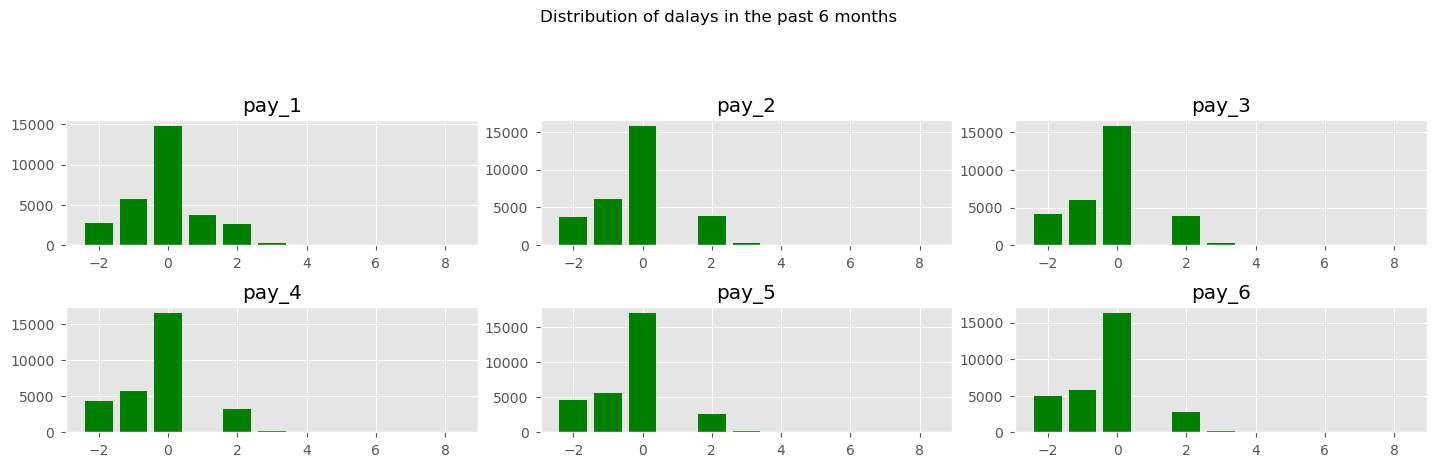

In [10]:
# pay status columns
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of dalays in the past 6 months')

for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = df[pay_status_columns[i]].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

As you can see some people pay 2 month upfront, others one month upfront, most of them are on par. a few are running behind payments. One thing worth of notice is that the textual information provided about this variables and the actual values are not extactly the same. So always look and explore the data, before proceeding with any analysis, explore and verify the actual data and the textual info about the data itself.

##### Standing credit
Let's look now at how the debts/credit is accumulating over the months, credit to be repaid is a positive number here.

In [11]:
# bill columns
pattern = re.compile("^bill_amt[0-9]+$")
bill_columns = [ x for x in df.columns if (pattern.match(x))]
df[bill_columns].describe()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [12]:
df[bill_columns].head(10)

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
0,3913,3102,689,0,0,0
1,2682,1725,2682,3272,3455,3261
2,29239,14027,13559,14331,14948,15549
3,46990,48233,49291,28314,28959,29547
4,8617,5670,35835,20940,19146,19131
5,64400,57069,57608,19394,19619,20024
6,367965,412023,445007,542653,483003,473944
7,11876,380,601,221,-159,567
8,11285,14096,12108,12211,11793,3719
9,0,0,0,0,13007,13912


##### Payments in the previous months
Let's have a quick look at how the payments are performed in the previous month.

In [13]:
# pay status columns
pattern = re.compile("^pay_amt[0-9]+$")
pay_amount_columns = [ x for x in df.columns if (pattern.match(x))]
df[pay_amount_columns].describe()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [14]:
df[pay_amount_columns].head(10)

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
0,0,689,0,0,0,0
1,0,1000,1000,1000,0,2000
2,1518,1500,1000,1000,1000,5000
3,2000,2019,1200,1100,1069,1000
4,2000,36681,10000,9000,689,679
5,2500,1815,657,1000,1000,800
6,55000,40000,38000,20239,13750,13770
7,380,601,0,581,1687,1542
8,3329,0,432,1000,1000,1000
9,0,0,0,13007,1122,0


In [15]:
df['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

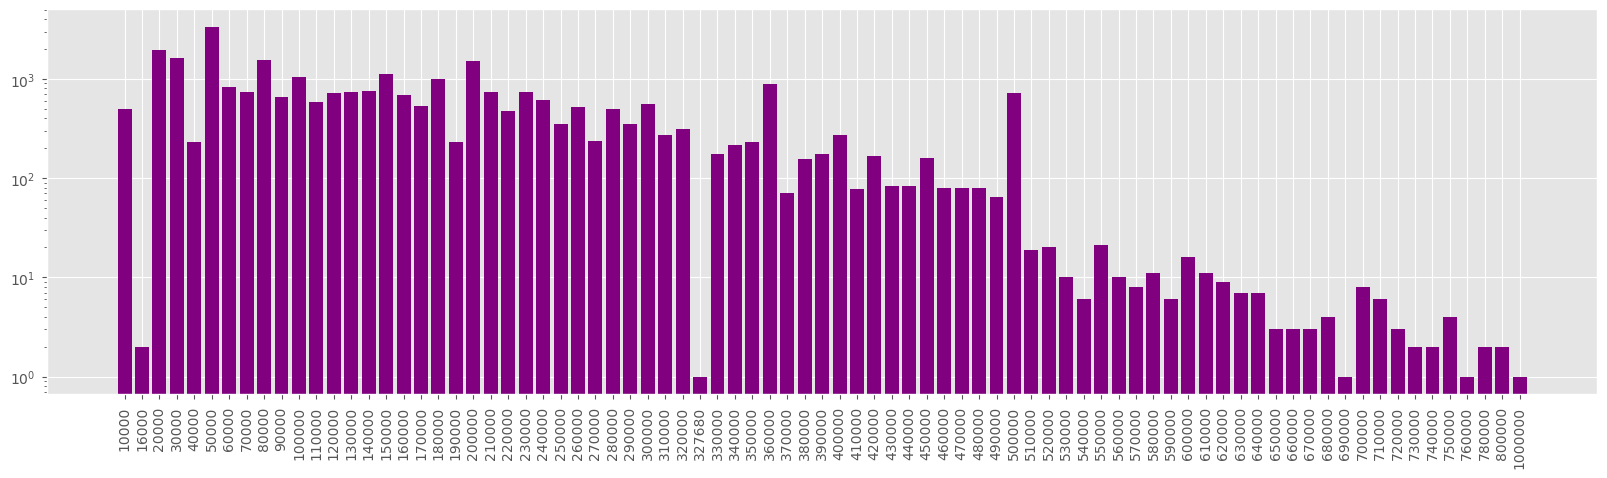

In [16]:
# limit balance
fig = plt.figure()
fig.set_size_inches(20,5)
ax = fig.add_subplot(111)

d = df.groupby(['limit_bal']).size()
ax.set_yscale("log")
ax.set_xticks(np.arange(len(d)))
ax.set_xticklabels(['%d' % i for i in d.index], rotation='vertical')
p = ax.bar(np.arange(len(d)), d, color='purple')

#### Explore Defaulting

First off, let's start with a zoomed out view on the problem.  
We want to predict defaulting, Let's answer the following questions:

  - how many cases do we have on our dataset to work with? 
  - What is the breakdown depending on some of the variables available?

defaulting accounts are 22.12% out of 30000 observations


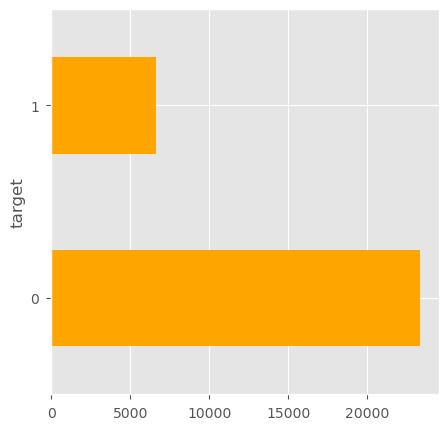

In [17]:
fig = plt.figure()
fig.set_size_inches(5,5)
d = df.groupby(['target']).size()

print("defaulting accounts are {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')


#### Explore some statistics of defaulting using the categorical variables

Let's have a look at a number of histograms to see how defaulting correlated with the categorical variables available, before that let's make use of categorical features of pandas, by converting target, sex, marriage, education, age and the pay_\* columns to categories

In [18]:
df['sex'] = df['sex'].astype('category').cat.rename_categories(['M', 'F'])
df['marriage'] = df['marriage'].astype('category').cat.rename_categories(['na', 'married', 'single', 'other'])


In [19]:
df['age_cat'] = pd.cut(df['age'], range(0, 100, 10), right=False)

In [20]:
pattern = re.compile("^pay_[0-9]+$")
pay_status_columns = [ x for x in df.columns if (pattern.match(x))]
for i in pay_status_columns:
    df[i] = df[i].astype('category')

### Absolute statistics

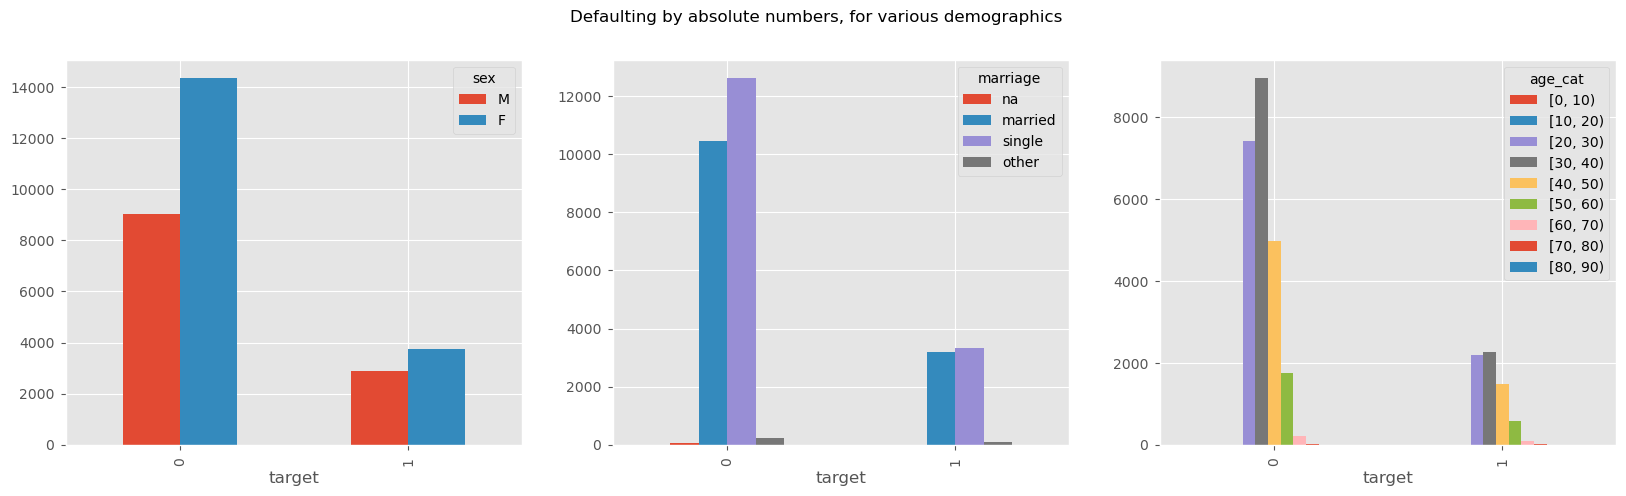

In [21]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by absolute numbers, for various demographics')

d = df.groupby(['target', 'sex']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size()
p = d.unstack(level=1).plot(kind='bar', ax=ax[2])

#### Statistics relative to the population

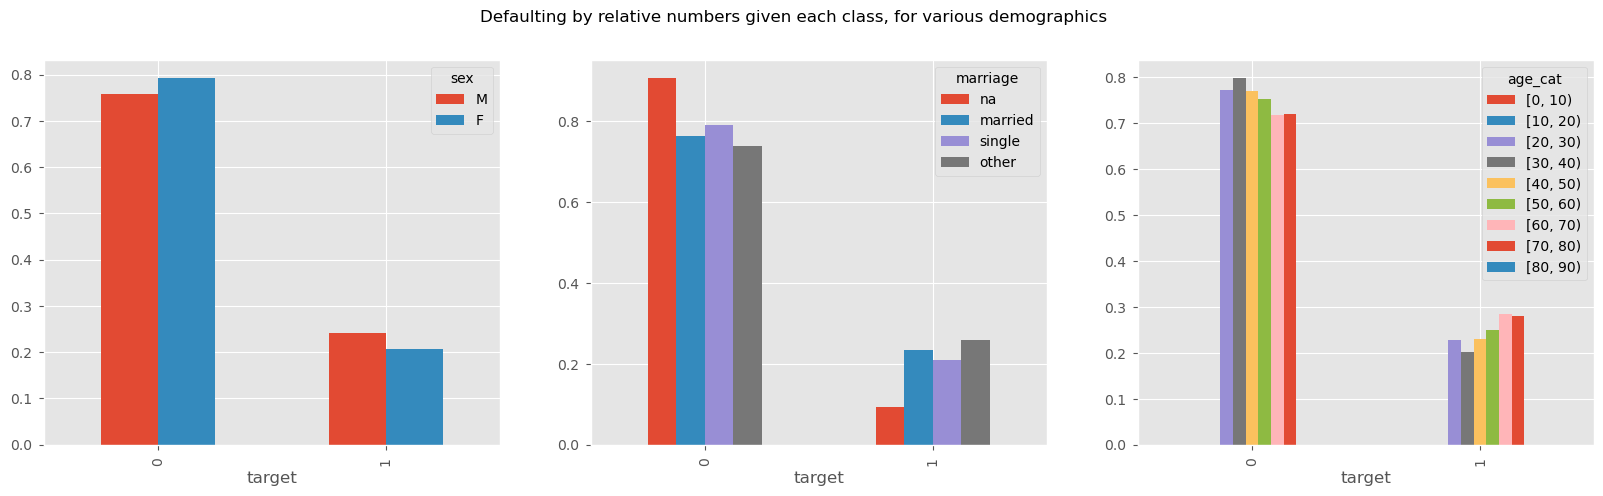

In [22]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = df.groupby(['target', 'sex']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = df.groupby(['target', 'marriage']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = df.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])

### Feature engineering

It's not about blind feature conversion to values between 0 and 1, it's about understanding data. In this case we see that payment they exibits a log/log distribution, so first off, we are going to take the log of the payments.

In [23]:
# help func
def selcols(prefix, a=1, b=6):
    return [prefix+str(i) for i in np.arange(a,b+1)]

In [24]:
from math import log

# average and standard deviation payment status
df['pay_avg'] = df[selcols('pay_')].mean(axis=1)
df['pay_std'] = df[selcols('pay_')].std(axis=1)

In [25]:
# average payment
df['pay_amt_avg']     = df[selcols('pay_amt')].mean(axis=1)

# log of average
df['pay_amt_avg_log'] = df['pay_amt_avg'].apply(lambda x: log(x+1))

#amounts relative to the average payment
for i in np.arange(1,7):
    df['pay_relamt'+str(i)] = df['pay_amt'+str(i)]/df['pay_amt_avg']

# log of payments
for i in np.arange(1,7):
    df['pay_amt_log'+str(i)] = df['pay_amt'+str(i)].apply(lambda x: log(x+1))

In [26]:
# average bill
df['bill_amt_avg'] = df[selcols('bill_amt')].mean(axis=1)
df['bill_amt_avg_log'] = df['bill_amt_avg'].apply(lambda x: log(x+1) if x>0 else 0)

# bill sign as a separate feature
for i in np.arange(1,7):
    df['bill_amt_sign'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: float(x>0))
    
# bill log as a separate feature (0 if bill is negative)
for i in np.arange(1,7):
    df['bill_amt_log'+str(i)] = df['bill_amt'+str(i)].apply(lambda x: log(x+1) if x>0 else 0)
    
#bill amounts relative to the limit
for i in np.arange(1,7):
    df['bill_relamt'+str(i)] = df['bill_amt'+str(i)]/df['limit_bal']


In [27]:
#log of credit limit
df['limit_bal_log'] = df['limit_bal'].apply(lambda x: log(x+1))
df['limit_bal_cat'] = pd.cut(df['limit_bal'], range(0, int(1e6), 10000), right=False)

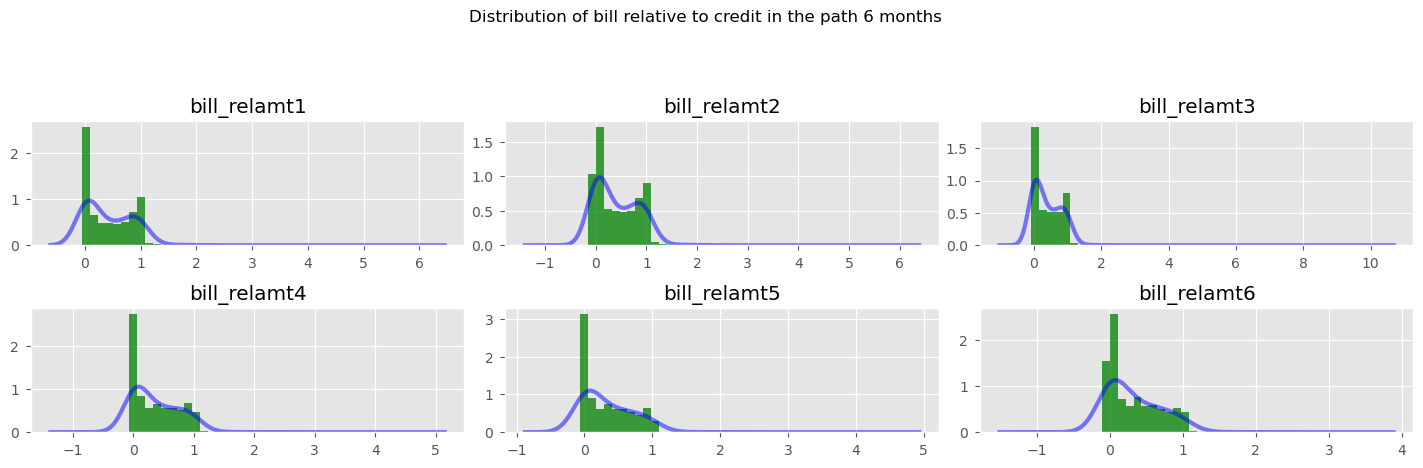

In [28]:
from sklearn.neighbors import KernelDensity

pattern = re.compile("^bill_relamt[0-9]+$")
columns = [ x for x in df.columns if (pattern.match(x))]

fig, ax = plt.subplots(2,3)
fig.set_size_inches(15,5)
fig.suptitle('Distribution of bill relative to credit in the path 6 months')

for i in range(len(columns)):
    row,col = int(i/3), i%3

    d = df[columns[i]]
    # the histogram of the data
    n, bins, patches = ax[row,col].hist(d, 50, density=1, facecolor='green', alpha=0.75)

    # kernel density estimation
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(d.values.reshape(-1, 1))
    x_grid = np.linspace(d.min(), d.max(), 1000)
    log_pdf = kde.score_samples(x_grid.reshape(-1, 1))

    # add the density line
    ax[row,col].plot(x_grid, np.exp(log_pdf), color='blue', alpha=0.5, lw=3)
    ax[row,col].set_title(columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

Intuition: if the credit is much larger than the bill, being behind might not be a problem. Therefore this contructed feature mightturn up useful when predicting defaulting

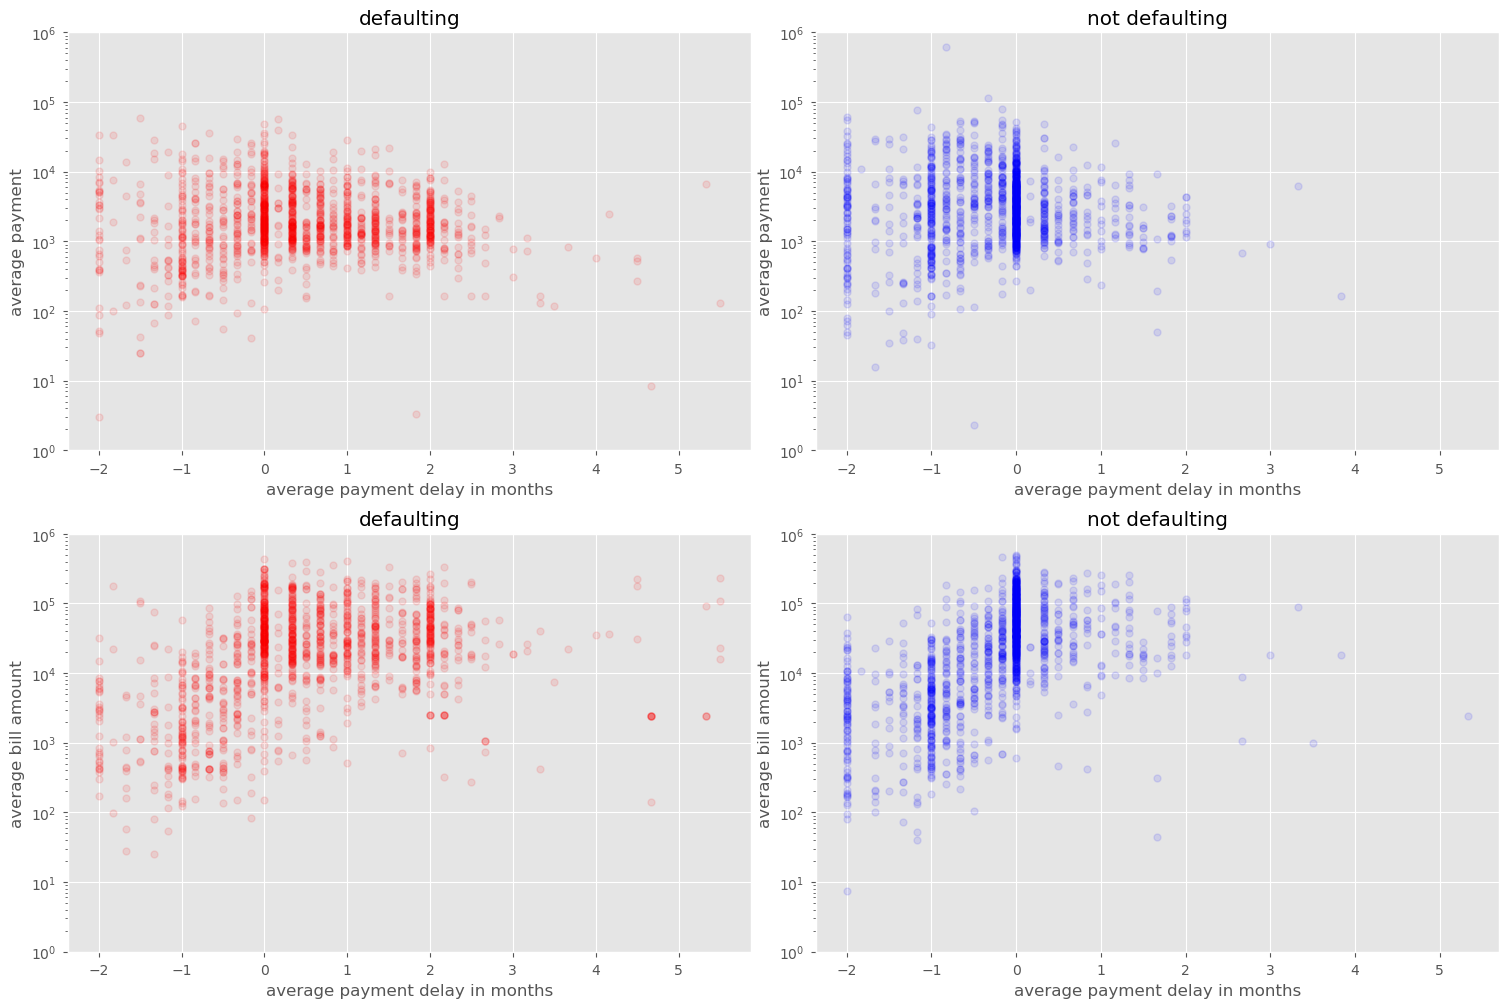

In [29]:
def_no = df[df['target']==0].sample(1500)
def_yes  = df[df['target']==1].sample(1500)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(15,10)

ax[0,0].set_ylim([1,1e6])
ax[0,0].set_title('defaulting')
ax[0,0].set_ylabel('average payment')
ax[0,0].set_xlabel('average payment delay in months')
p = ax[0,0].semilogy(def_yes['pay_avg'], def_yes['pay_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[0,1].set_ylim([1,1e6])
ax[0,1].set_title('not defaulting')
ax[0,1].set_ylabel('average payment')
ax[0,1].set_xlabel('average payment delay in months')
p = ax[0,1].semilogy(def_no['pay_avg'], def_no['pay_amt_avg'], 'bo', markersize=5, alpha=0.1)

ax[1,0].set_ylim([1,1e6])
ax[1,0].set_title('defaulting')
ax[1,0].set_ylabel('average bill amount')
ax[1,0].set_xlabel('average payment delay in months')
p = ax[1,0].semilogy(def_yes['pay_avg'], def_yes['bill_amt_avg'], 'ro', markersize=5, alpha=0.1)

ax[1,1].set_ylim([1,1e6])
ax[1,1].set_title('not defaulting')
ax[1,1].set_ylabel('average bill amount')
ax[1,1].set_xlabel('average payment delay in months')
p = ax[1,1].semilogy(def_no['pay_avg'], def_no['bill_amt_avg'], 'bo', markersize=5, alpha=0.1)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

#### From variables to train, test matrices

In [30]:
from patsy import dmatrices

formula  = 'target ~ '

# original features
formula += 'C(sex) + C(marriage) +  C(education) + age'
formula += '+' + '+'.join(selcols('pay_'))

#### engineered / normalized features

# categorical age and credit limit (binned)
formula += '+' + 'C(age_cat)'
formula += '+' + 'C(limit_bal_cat) + limit_bal_log'

#pay delays
formula += '+' + 'pay_avg + pay_std'
    
#pay_amt
formula += '+' + 'pay_amt_avg_log'
formula += '+' + '+'.join(selcols('pay_relamt'))
formula += '+' + '+'.join(selcols('pay_amt_log'))

# bill amounts
formula += '+' + 'bill_amt_avg_log'
formula += '+' + '+'.join(selcols('bill_relamt'))
formula += '+' + '+'.join(selcols('bill_amt_sign'))
formula += '+' + '+'.join(selcols('bill_amt_log'))

y, X = dmatrices(formula, data=df, return_type='dataframe')
y = y.iloc[:, 1]

#### Visualization: Confusion matrices and AUC curves

In [31]:
import itertools
from sklearn.metrics import roc_curve, auc, precision_recall_curve,roc_auc_score, log_loss, \
accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def plot_cm(ax, y_true, y_pred, classes, title, th=0.5, cmap=plt.cm.Blues):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_true, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def plot_auc(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
    roc_auc_train = auc(fpr_train, tpr_train)
    acc_train = accuracy_score(y_train, y_train_pred_labels)

    fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
    roc_auc_test = auc(fpr_test, tpr_test)
    acc_test = accuracy_score(y_test, y_test_pred_labels)

    ax.plot(fpr_train, tpr_train)
    ax.plot(fpr_test, tpr_test)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.2f}, auc = {:.2f}'.format(acc_train, roc_auc_train)
    test_text = 'test acc = {:.2f}, auc = {:.2f}'.format(acc_test, roc_auc_test)
    no_skill_text = 'no skill'
    ax.legend([train_text, test_text, no_skill_text])
    
def plot_prec_rec(ax, y_train, y_train_pred, y_test, y_test_pred, th=0.5):

    y_train_pred_labels = (y_train_pred>th).astype(int)
    y_test_pred_labels  = (y_test_pred>th).astype(int)

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_pred)
    precision_score_train = precision_score(y_train, y_train_pred_labels)
    recall_score_train = recall_score(y_train, y_train_pred_labels)
    f1_score_train = f1_score(y_train, y_train_pred_labels)
  
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred)
    precision_score_test = precision_score(y_test, y_test_pred_labels)
    recall_score_test = recall_score(y_test, y_test_pred_labels)
    f1_score_test = f1_score(y_test, y_test_pred_labels)

    ax.plot(recall_train, precision_train)
    ax.plot(recall_test, precision_test)

    no_skill = len(y_train[y_train==1]) / len(y_train)
    ax.plot([0, 1], [no_skill, no_skill], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    
    train_text = 'train precision = {:.2f}, recall = {:.2f}, f1 = {:.2f}'.format(precision_score_train, recall_score_train, f1_score_train)
    test_text = 'test precision = {:.2f}, recall = {:.2f}, f1 = {:.2f}'.format(precision_score_test, recall_score_test, f1_score_test)
    no_skill_text = 'no skill'
    ax.legend([train_text, test_text, no_skill_text])


#### Feature selection



In [37]:
import warnings
from sklearn.feature_selection import SelectKBest, f_classif,chi2

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif)

selector.fit(X, y)

SelectKBest()

In [38]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-25:][::-1]
selector.scores_[top_indices]
X.columns[top_indices]

Index(['pay_1[T.2]', 'pay_2[T.2]', 'pay_avg', 'pay_3[T.2]', 'pay_4[T.2]',
       'pay_5[T.2]', 'pay_std', 'pay_6[T.2]', 'pay_1[T.0]', 'limit_bal_log',
       'pay_amt_log1', 'pay_amt_avg_log', 'bill_relamt6', 'pay_2[T.0]',
       'bill_relamt5', 'bill_relamt4', 'pay_amt_log2', 'bill_relamt3',
       'bill_relamt2', 'pay_amt_log3', 'pay_1[T.3]', 'bill_relamt1',
       'pay_2[T.3]', 'pay_3[T.0]', 'pay_amt_log4'],
      dtype='object')

Remarks: Looks like some of the constructed features are indeed beneficial.
Also it seems that demographics are only marginally influencing the prediction.
paid amounts, delays, and bill relative to credit issued are top indicators. Interestingly education score quite high as a a predictive feature.

#### Feature scaling



In [39]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
scaler.fit(X)

MinMaxScaler()

In [40]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([('anova', selector), ('scale', scaler)])
preprocess.fit(X,y)

X_prep = preprocess.transform(X)

#### Model selection and validation

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, test_size=0.2, random_state=42)

### Models
#### Logistic regression (baseline models)

In [42]:
from sklearn import linear_model

# Create logistic regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LogisticRegression()

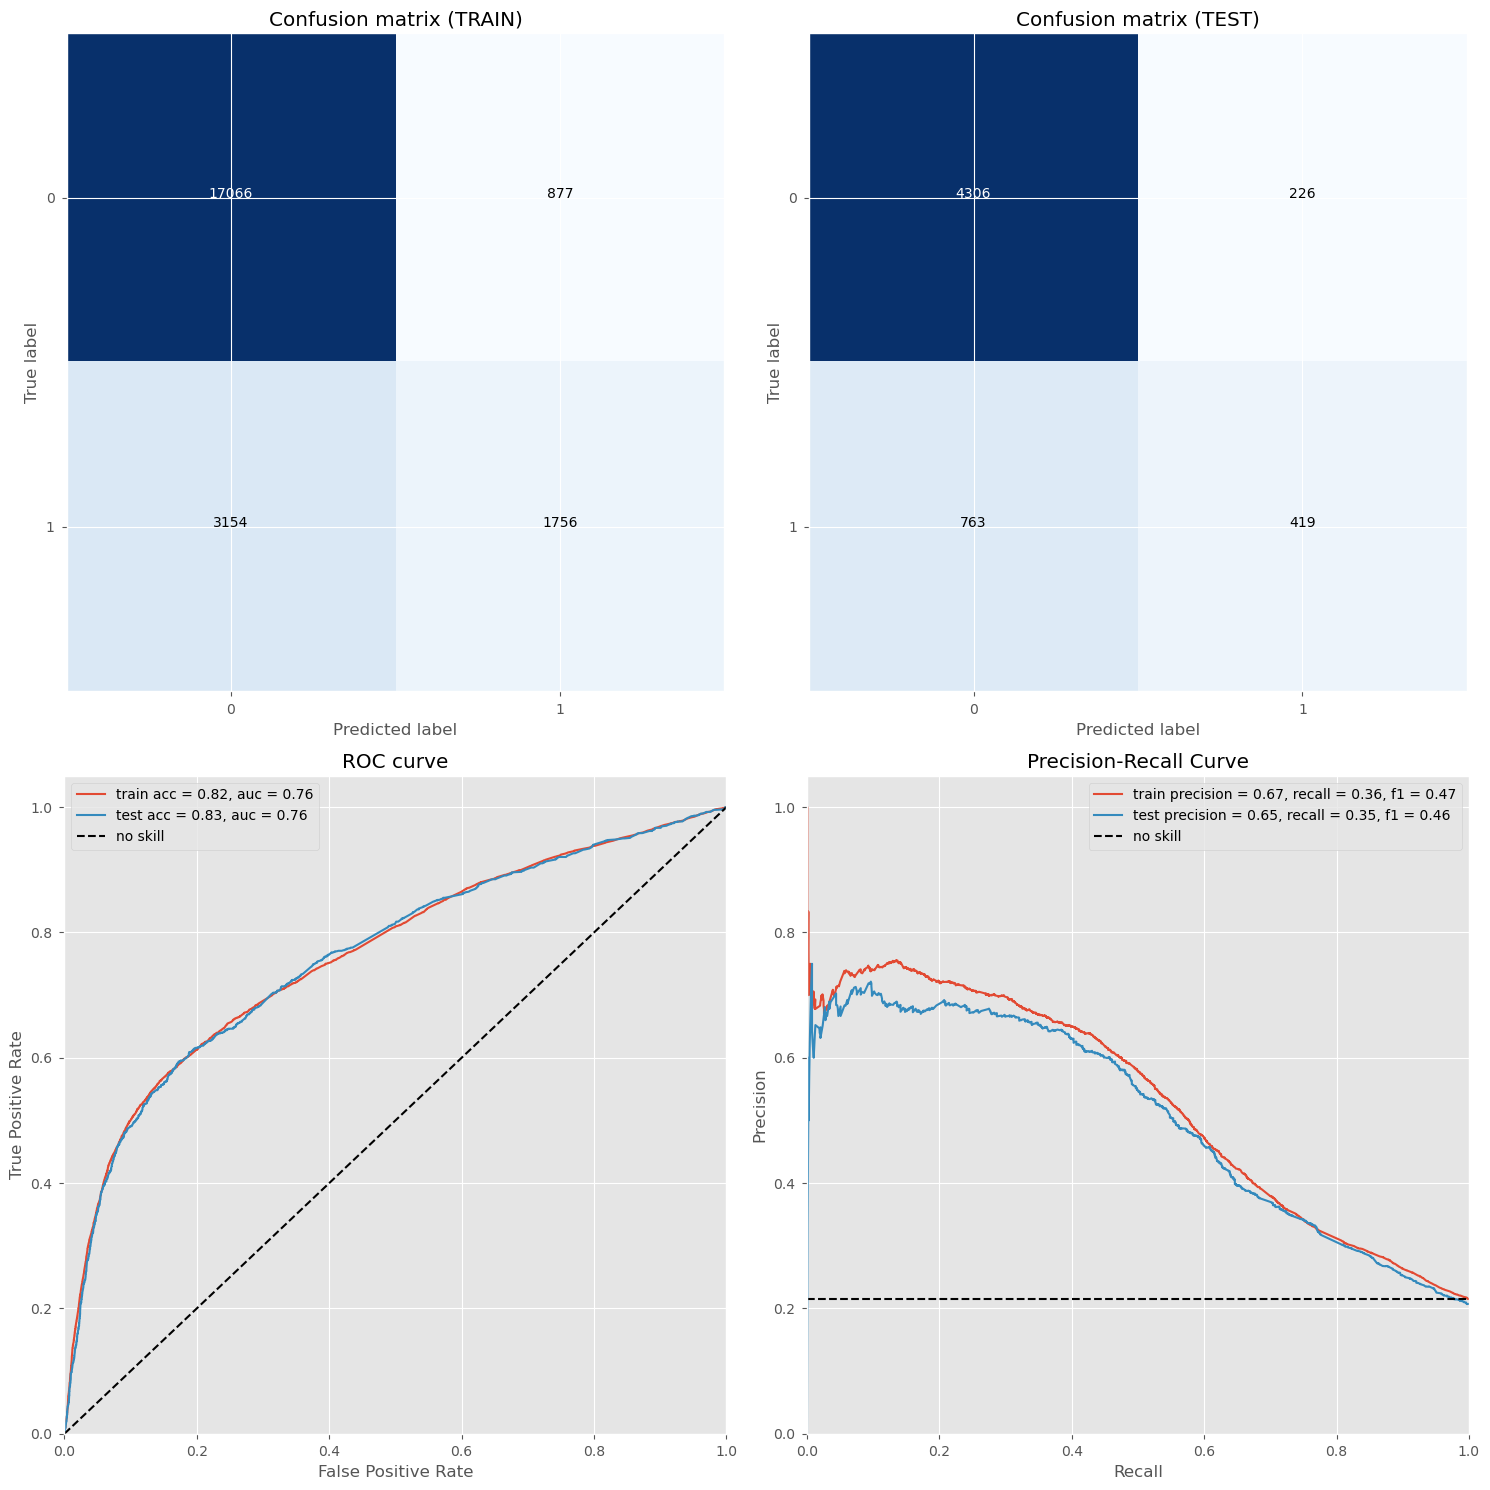

In [43]:
y_train_pred = regr.predict_proba(X_train)[:,1]
y_test_pred = regr.predict_proba(X_test)[:,1]

threshold = 0.5
   
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15,15)

plot_cm(ax1,  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax2,  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax3, y_train, y_train_pred, y_test, y_test_pred, threshold)
plot_prec_rec(ax4, y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

#### Random Forest 
Quite popular a few years back, bootstrap aggregating ensamble of decision trees

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
rf.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=5, n_estimators=500)

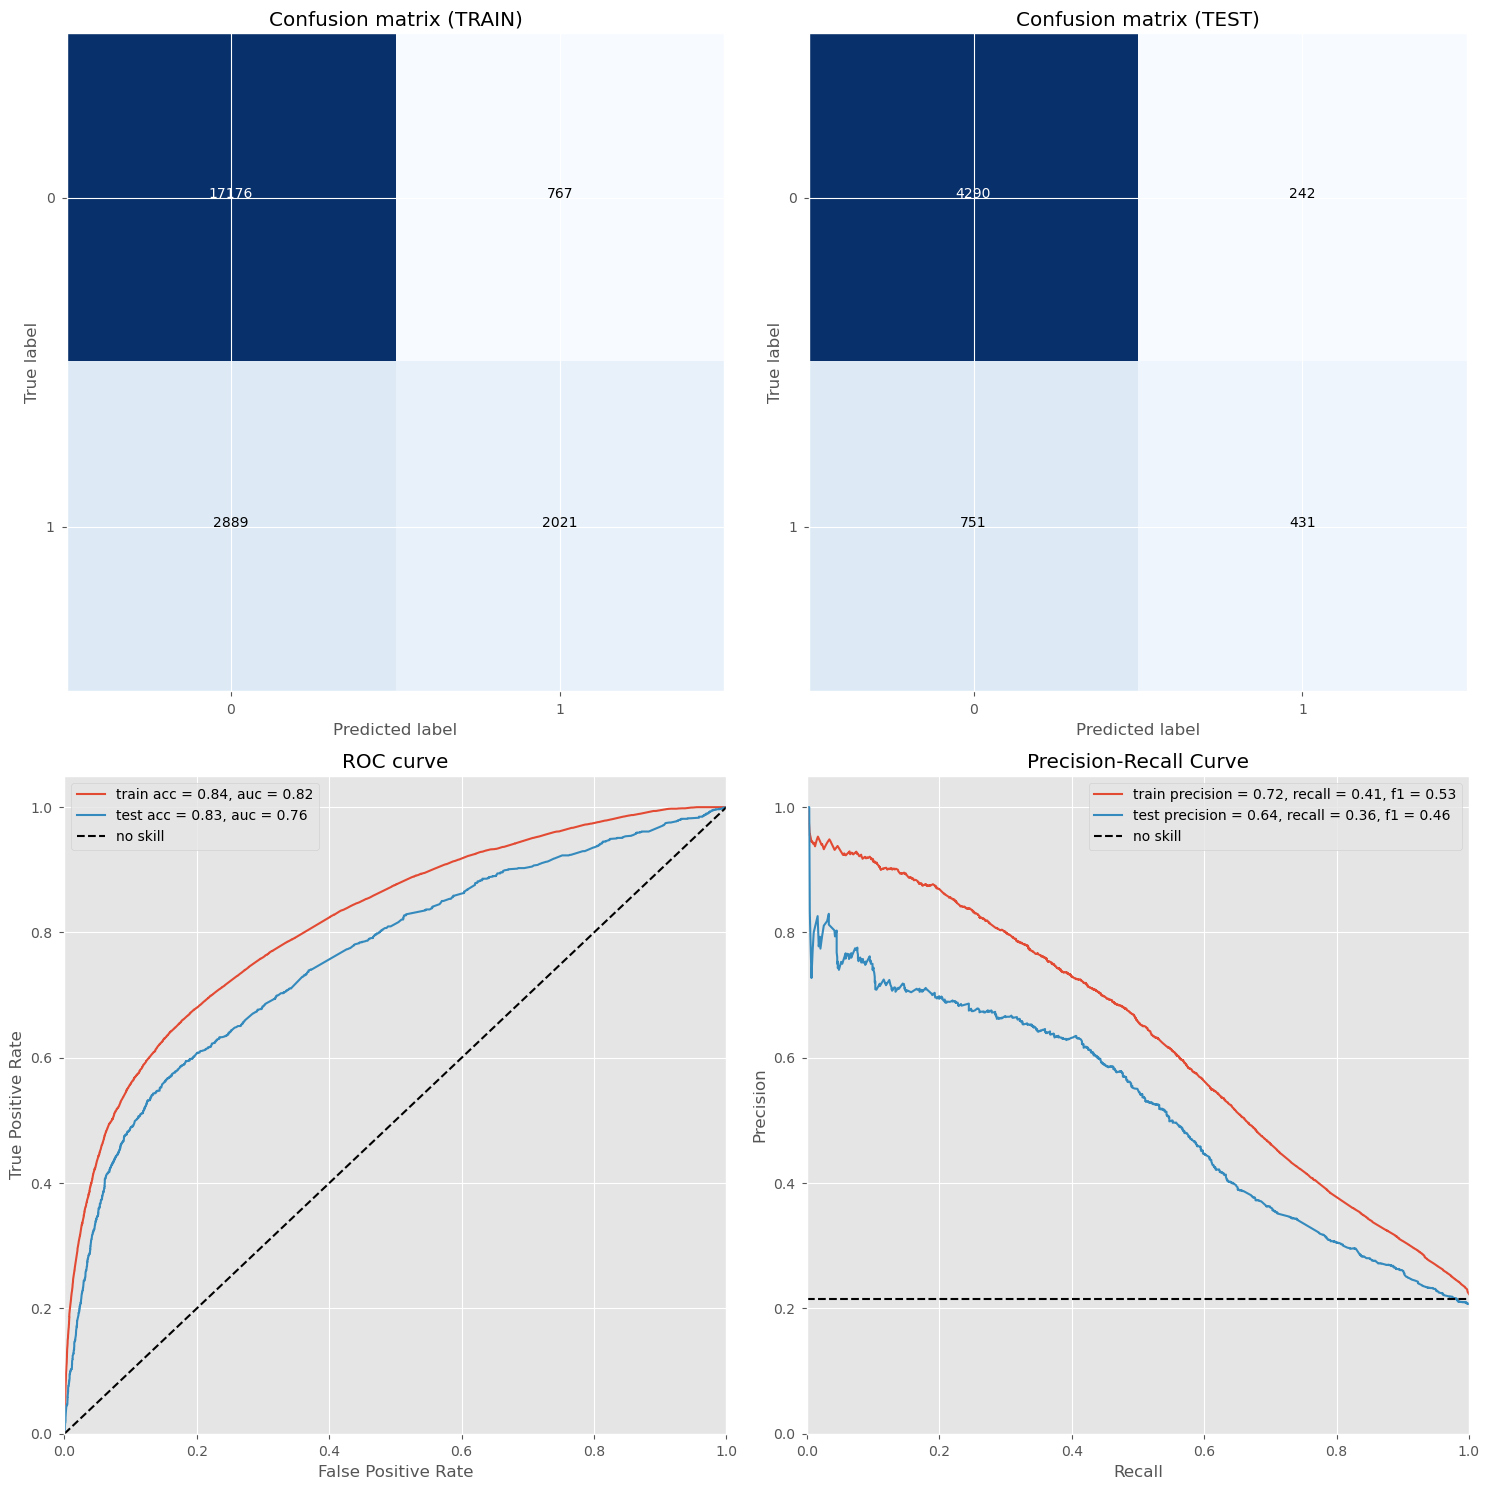

In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score

threshold = 0.5
y_train_pred = rf.predict_proba(X_train)[:,1]
y_test_pred = rf.predict_proba(X_test)[:,1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15,15)

plot_cm(ax1,  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax2,  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax3, y_train, y_train_pred, y_test, y_test_pred, threshold)
plot_prec_rec(ax4, y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()

#### Decision Trees boosting

An iterative model for refining a model by looking at the remainder error.

In [46]:
import xgboost as xgb

In [47]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [48]:
num_round = 5
evallist  = [(dtest,'eval'), (dtrain,'train')]
param = {'objective':'binary:logistic', 'silent':1, 'eval_metric': ['error', 'logloss']}

bst = xgb.train( param, dtrain, num_round, evallist )

[19:04:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	eval-error:0.17343	eval-logloss:0.57271	train-error:0.17087	train-logloss:0.57147
[1]	eval-error:0.17361	eval-logloss:0.50906	train-error:0.16974	train-logloss:0.50673
[2]	eval-error:0.17291	eval-logloss:0.47249	train-error:0.16926	train-logloss:0.46985
[3]	eval-error:0.17221	eval-logloss:0.45131	train-error:0.16899	train-logloss:0.44795
[4]	eval-error:0.17133	eval-logloss:0.43884	train-error:0.16803	train-logloss:0.43476


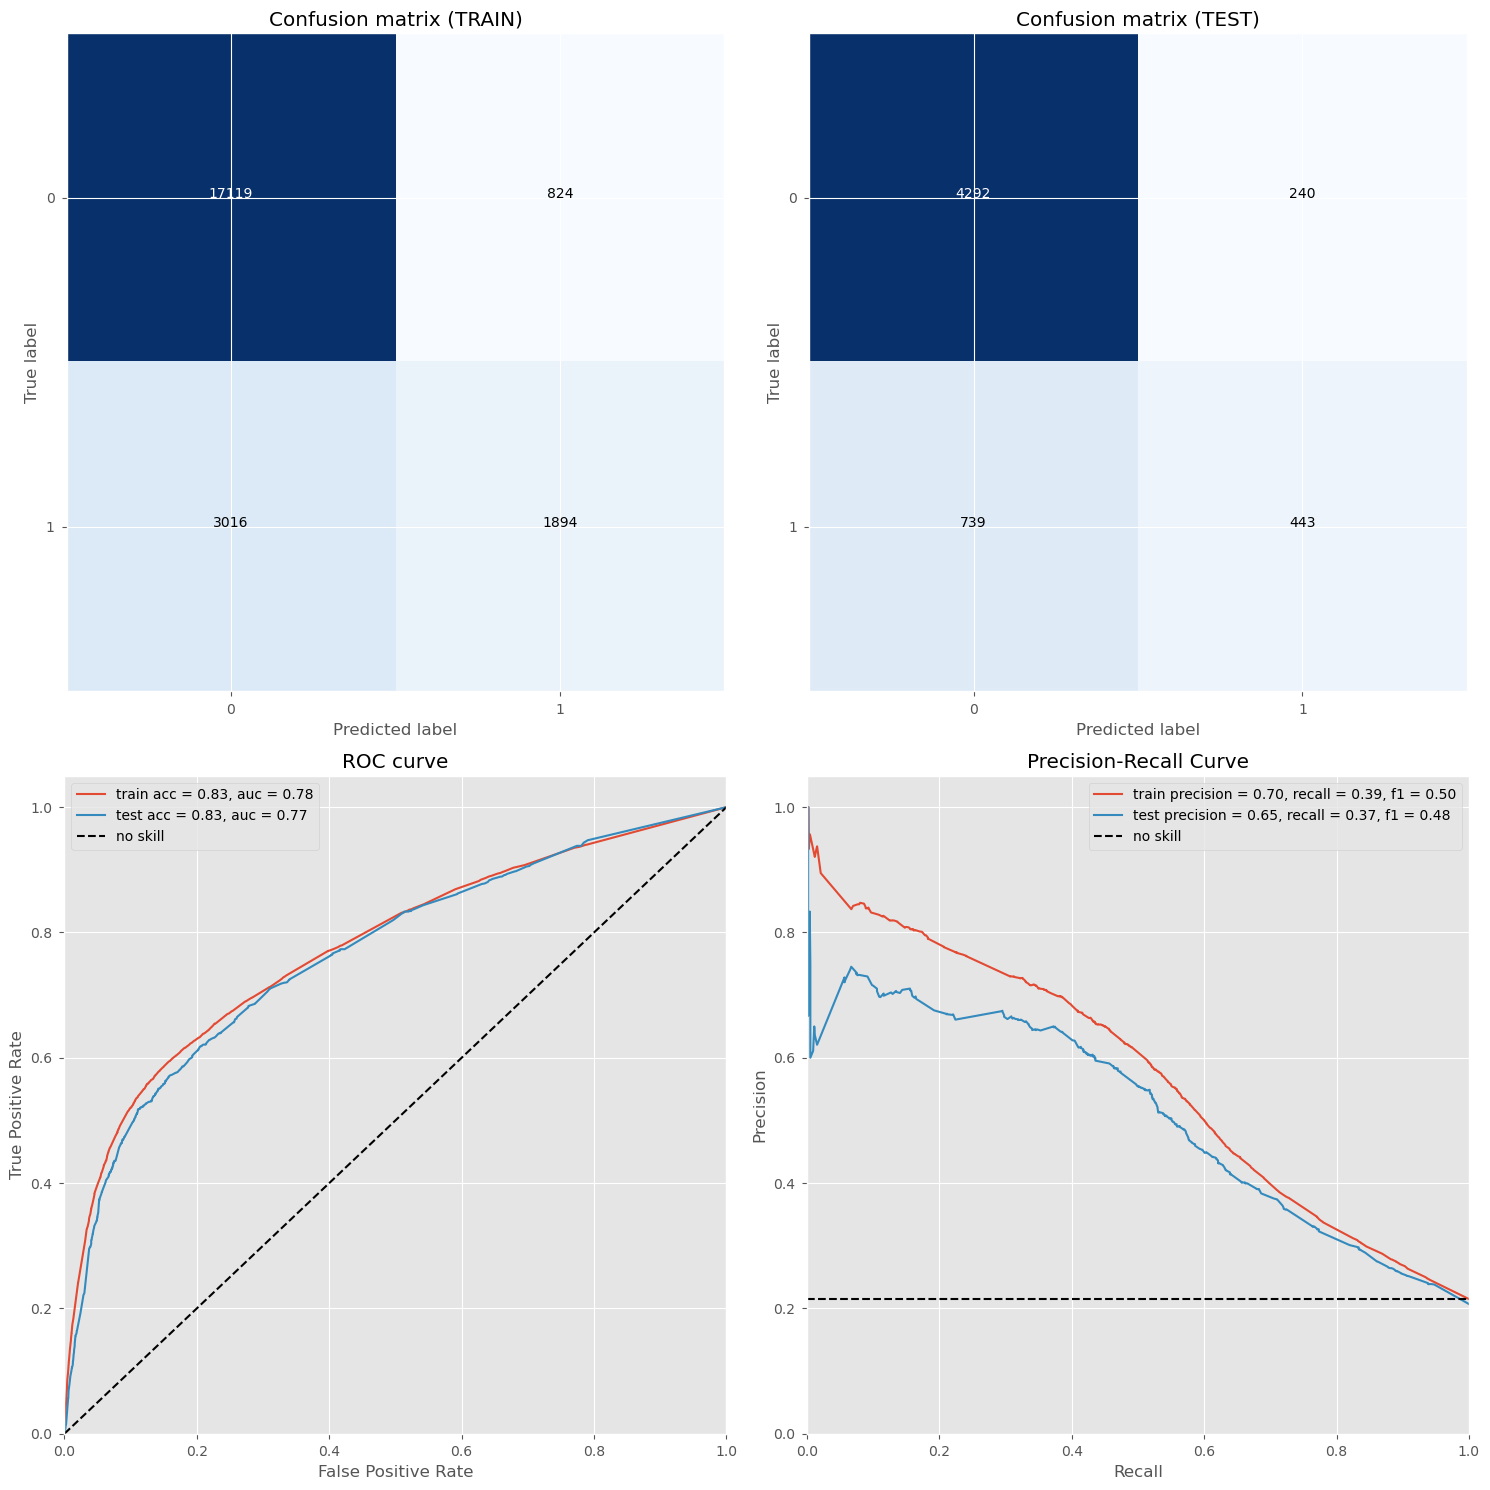

In [49]:
threshold = 0.5
y_train_pred = bst.predict(dtrain)
y_test_pred = bst.predict(dtest)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(15,15)

plot_cm(ax1,  y_train, y_train_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
plot_cm(ax2,  y_test, y_test_pred,   [0,1], 'Confusion matrix (TEST)', threshold)
plot_auc(ax3, y_train, y_train_pred, y_test, y_test_pred, threshold)
plot_prec_rec(ax4, y_train, y_train_pred, y_test, y_test_pred, threshold)
    
plt.tight_layout()
plt.show()